<a href="https://colab.research.google.com/github/aliaa-anx/celebrity-recognition-model/blob/aliaa/VGG_19_model_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os


In [3]:
import zipfile
import os
zip_path = "/content/drive/MyDrive/VGGFace2_balanced_900_albumentations.zip"
extract_path = "/content/dataset"     # folder where files will be extracted
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")
# List the first few items
print(os.listdir(extract_path))


Dataset unzipped successfully!
['VGGFace2_balanced_900_albumentations']


In [4]:
import random
dataset_path = "/content/dataset/VGGFace2_balanced_900_albumentations"

valid_ext = (".jpg", ".jpeg", ".png")
all_image_paths = [
    os.path.join(dp, f)
    for dp, dn, files in os.walk(dataset_path)
    for f in files if f.lower().endswith(valid_ext)
]
random.shuffle(all_image_paths)



In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os

dataset_path = "/content/dataset/VGGFace2_balanced_900_albumentations"
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

IMAGE_SIZE = (224, 224)
target_per_class = 1500

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg','.png'))]
    num_existing = len(images)
    idx = 0
    while num_existing < target_per_class:
        img_path = os.path.join(class_folder, images[idx % len(images)])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        img = np.expand_dims(img, 0)

        for batch in datagen.flow(img, batch_size=1):
            aug_img = batch[0].astype(np.uint8)
            save_path = os.path.join(class_folder, f"aug_{num_existing}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            num_existing += 1
            break
        idx += 1

print("Dataset expanded to 1500 images per class!")


Dataset expanded to 1500 images per class!


normalization

In [6]:
import os
import random
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 15
# 3. Create dataset paths and shuffle

random.seed(42)
random.shuffle(all_image_paths)

print(f"Total images found: {len(all_image_paths)}")

# 3. SPLIT DATA (70% Train, 15% Val, 15% Test)
total_images = len(all_image_paths)
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size + val_size]
test_paths = all_image_paths[train_size + val_size:]

print(f"Training: {len(train_paths)}, Validation: {len(val_paths)}, Test: {len(test_paths)}")


Total images found: 13500
Training: 9450, Validation: 2025, Test: 2025


In [7]:
# Map class names to integers
dataset_path = os.path.join(extract_path, "VGGFace2_balanced_900_albumentations")
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
class_to_int = {c:i for i,c in enumerate(sorted(os.listdir(dataset_path)))}


def process_path(file_path):
    # extract class folder name
    class_name = tf.strings.split(file_path, "/")[-2]

    # Python function to convert class name → label
    def get_label(x):
        x = x.numpy().decode("utf-8")   # convert Tensor → Python string
        return class_to_int[x]

    label = tf.py_function(get_label, [class_name], Tout=tf.int32)
    label.set_shape([])

    # load image
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)

    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(train_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
val_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(val_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
test_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(test_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))

print("Datasets ready ")



Datasets ready 


In [8]:


def build_vgg19_model(input_shape, num_classes):
    model = models.Sequential(name="VGG-19")




    model.add(layers.Input(shape=input_shape))


    # Block 1  contains 2 convultional layers and 1 max pooling layer
    # activation relu>> to add complexity and non-linearity to the model
    #padding same>> to maintain the spatial dimensions of the input (will be halved after max pooling)

    # first and 2nd blocks have 64 filters each and rest of the blocks as we go
    # deeper will have 128,256,512,512 filters respectively  to notioce more complex features as we go deeper


    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 2 contains 2 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 3 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 4 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 5 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))


    # Flattening the layers to feed into fully connected layers(Dense layers considered the brain of the model)
    #model.add(layers.Flatten())

    #we have 3 dense layers in VGG-19
    #OPTION1 (HIGH RAM usage)
    # dense layer-1 with 4096 neurons and relu activation function
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dropout(0.5)) #dropout to prevent overfitting


    # dense layer-2 with 4096 neurons and relu activation function
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dropout(0.5))

    #less ram usage by 50%

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))




    return model

print("VGG-19 architecture defined. ")

VGG-19 architecture defined. 


In [9]:
# full_dataset is your ImageFolder before splitting
num_classes = 15

input_shape = (224, 224, 3)  # for VGG-19

model = build_vgg19_model(input_shape, num_classes)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "VGG-19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,294,735 (77.42 MB)

 Trainable params: 20,294,735 (77.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam

# Adam optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the Keras model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  #keras map file names to integers
    metrics=['accuracy']
)

print("Optimization setup done. Using Adam optimizer for Keras model.")


Optimization setup done. Using Adam optimizer for Keras model.


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Save the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    "/content/drive/MyDrive/best_vgg19_model.keras",   # file to save the model
    monitor="val_accuracy",  # metric to monitor
    save_best_only=True,     # save only the best version
    mode="max",
    verbose=1
)

# Optional: stop training early if no improvement
earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,             # stop if no improvement for 5 epochs
    restore_best_weights=True,
    verbose=1
)


In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,               # to test
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.0684 - loss: 2.7111
Epoch 1: val_accuracy improved from -inf to 0.06963, saving model to /content/drive/MyDrive/best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 289s 825ms/step - accuracy: 0.0684 - loss: 2.7111 - val_accuracy: 0.0696 - val_loss: 2.7067
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.0622 - loss: 2.7084
Epoch 2: val_accuracy did not improve from 0.06963
296/296 ━━━━━━━━━━━━━━━━━━━━ 188s 635ms/step - accuracy: 0.0622 - loss: 2.7084 - val_accuracy: 0.0573 - val_loss: 2.7087
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.0761 - loss: 2.6977
Epoch 3: val_accuracy improved from 0.06963 to 0.13284, saving model to /content/drive/MyDrive/best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 188s 636ms/step - accuracy: 0.0761 - loss: 2.6975 - val_accuracy: 0.1328 - val_loss: 2.3032
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.1203 - loss: 2.3417
E

In [13]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/best_vgg19_model.keras")

from tensorflow.keras.optimizers import Adam

learning_rate = 1e-4
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",  # assuming integer labels
    metrics=["accuracy"]
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[checkpoint_cb, earlystop_cb],
)



Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6944 - loss: 0.8950
Epoch 1: val_accuracy improved from 0.64000 to 0.73679, saving model to /content/drive/MyDrive/best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 210s 676ms/step - accuracy: 0.6944 - loss: 0.8949 - val_accuracy: 0.7368 - val_loss: 0.7627
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7588 - loss: 0.7170
Epoch 2: val_accuracy improved from 0.73679 to 0.76840, saving model to /content/drive/MyDrive/best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 194s 655ms/step - accuracy: 0.7589 - loss: 0.7169 - val_accuracy: 0.7684 - val_loss: 0.6954
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7982 - loss: 0.5907
Epoch 3: val_accuracy improved from 0.76840 to 0.83556, saving model to /content/drive/MyDrive/best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 192s 650ms/step - accuracy: 0.7982 - loss: 0.5907 - val_accuracy: 0.8356 - val_loss: 0.5074
Epoch 4/100
296/

**evaluation**

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [15]:
# Evaluate on the test dataset to get the "Real" accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9098 - loss: 0.3930
Final Test Accuracy: 90.62%


Generating predictions....


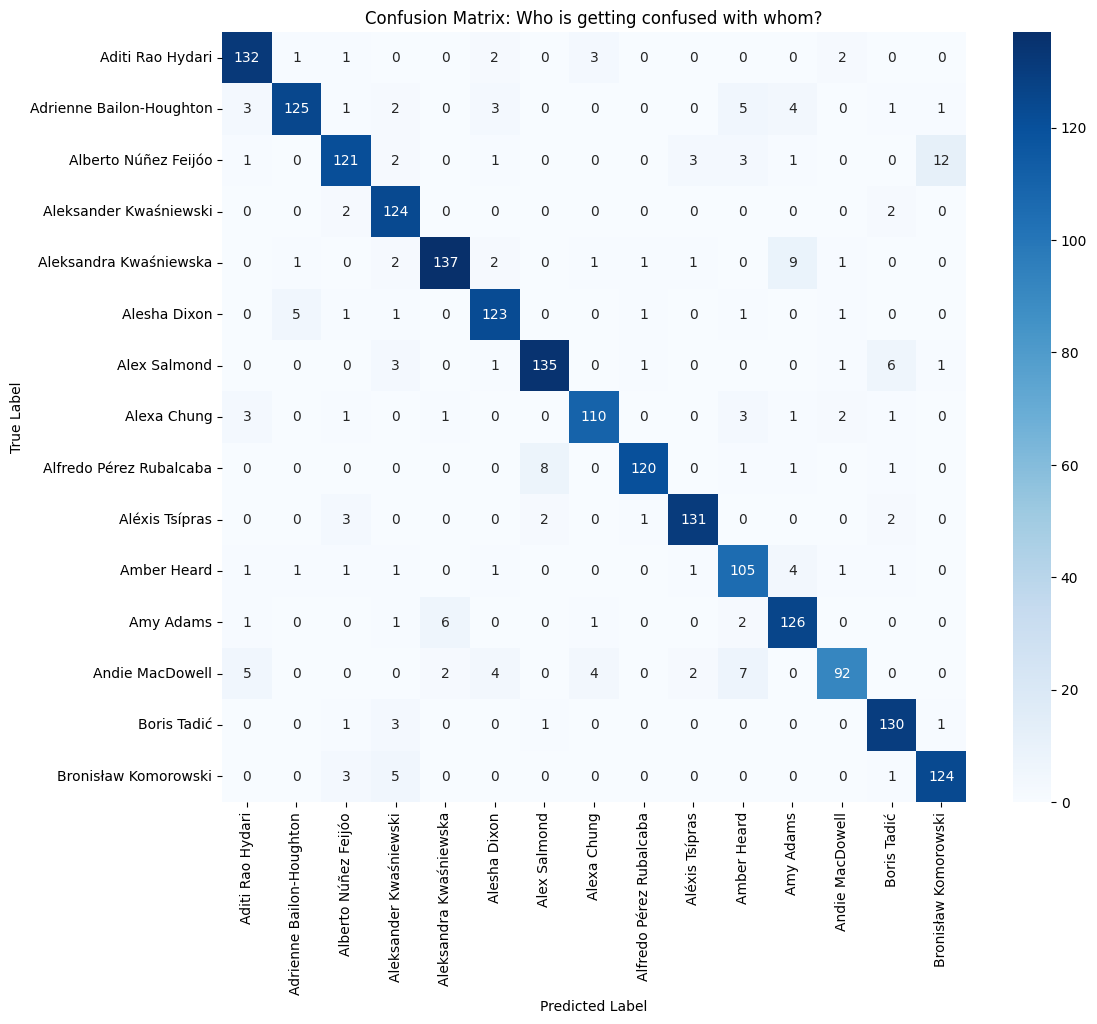

                          precision    recall  f1-score   support

        Aditi Rao Hydari       0.90      0.94      0.92       141
Adrienne Bailon-Houghton       0.94      0.86      0.90       145
    Alberto Núñez Feijóo       0.90      0.84      0.87       144
  Aleksander Kwaśniewski       0.86      0.97      0.91       128
  Aleksandra Kwaśniewska       0.94      0.88      0.91       155
            Alesha Dixon       0.90      0.92      0.91       133
            Alex Salmond       0.92      0.91      0.92       148
             Alexa Chung       0.92      0.90      0.91       122
 Alfredo Pérez Rubalcaba       0.97      0.92      0.94       131
          Aléxis Tsípras       0.95      0.94      0.95       139
             Amber Heard       0.83      0.90      0.86       117
               Amy Adams       0.86      0.92      0.89       137
         Andie MacDowell       0.92      0.79      0.85       116
             Boris Tadić       0.90      0.96      0.93       136
    Broni

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Get Predictions on Test Data
print("Generating predictions....")
y_true = []
y_pred = []

# Iterate over the test dataset to get actual vs predicted values
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    # Convert probabilities to class index (0, 1, 2...)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 2. Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Who is getting confused with whom?')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# 4. Print a Text Report (Precision/Recall per person)
print(classification_report(y_true, y_pred, target_names=class_names))

Getting predictions for ROC curve...


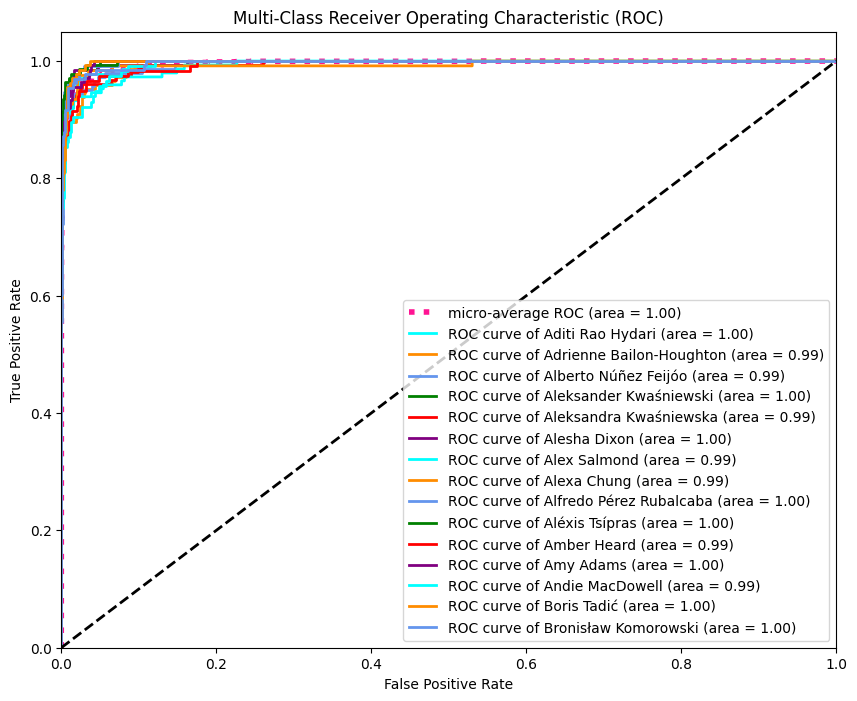

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

# 1. Get True Labels and Predicted Probabilities
print("Getting predictions for ROC curve...")
y_true_indices = []
y_probs = []

# Iterate through Test Dataset
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_probs.extend(preds)
    y_true_indices.extend(labels.numpy())

y_true_indices = np.array(y_true_indices)
y_probs = np.array(y_probs)

# 2. Binarize the labels (One-hot encoding for ROC)
lb = LabelBinarizer()
lb.fit(range(len(class_names)))
y_true_bin = lb.transform(y_true_indices)

# 3. Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Compute Micro-Average ROC (Overall performance)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 5. Plotting
plt.figure(figsize=(10, 8))

# Plot Micro-Average (The "Summary" Line)
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot each individual class curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()